In [1]:
# basic imports
import pandas as pd, matplotlib.pyplot as plt, numpy as np 
import IPython.display as ipd

In [2]:
# librosa - for CQT and visualisation
import librosa, librosa.display

In [3]:
# Interval for label storage
from intervaltree import Interval,IntervalTree

# Neural Network model training

## Import data

In [4]:
# import h5py to read in hdf5 files 
import h5py

filename ='musicnet.h5'
music_net = h5py.File(filename,'r')
type(music_net)

h5py._hl.files.File

In [5]:
# extract 20 songs from the database 
n = 20
i = 50 # start index
source_list = list(music_net.keys())[i:n+i]
source_list

['id_1872',
 'id_1873',
 'id_1876',
 'id_1893',
 'id_1916',
 'id_1918',
 'id_1919',
 'id_1922',
 'id_1923',
 'id_1931',
 'id_1932',
 'id_1933',
 'id_2075',
 'id_2076',
 'id_2077',
 'id_2078',
 'id_2079',
 'id_2080',
 'id_2081',
 'id_2082']

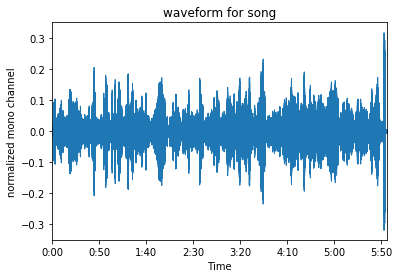

In [6]:
# plot the audio data for the third song 
librosa.display.waveplot(music_net[source_list[2]]['data'][()],
                         sr=44100,
                         x_axis= 'time');
plt.ylabel('normalized mono channel');
plt.title('waveform for song');

## Preprocessing

In [7]:
# init lists for storing results
cqt_container = [] # array to store the cqt for each song
cqt_shapes = [] # array to store the shapes of each cqt

print('initializing cqt transforms')
print('-'*60)
for id_ in source_list:
    print('extracting data from',id_)
    # extract the mono audio data and labels
    song = music_net[id_]
    music = song['data'][()]

    # downsampling
    sr = 44100
    sr_16k = 16000

    # resample to 16kHz to increase the the number of cqt points
    music = librosa.resample(music,sr,sr_16k)

    # CQT parameters
    sr_16k = sr_16k # downsampling to 16kHz
    hop_length = 512 # 32ms frames  
    bins_per_octave = 36 # corresponds to 7 octaves on the piano 
    # 7 x 36 = 252 number of bins 
    n_bins = 252 # frequency resolution 
    window = 'hann' # hanning window for smoothness

    # CQT absolute magnitude 
    C = np.abs(librosa.cqt(music,
                           sr = sr_16k , 
                           hop_length = hop_length,
                           bins_per_octave = bins_per_octave,
                           window = window,
                           n_bins = n_bins))
    # transpose to get the array in the correct format
    C = np.transpose(C)
    
    # append the length of this cqt to the length array 
    cqt_shapes.append(C.shape)
    
    # append to container
    cqt_container.append(C)

print('-'*60)
print('CQT transformation on each song complete')
print('-'*60)
print('CQT dimensions:', cqt_shapes)

initializing cqt transforms
------------------------------------------------------------
extracting data from id_1872
extracting data from id_1873
extracting data from id_1876
extracting data from id_1893
extracting data from id_1916
extracting data from id_1918
extracting data from id_1919
extracting data from id_1922
extracting data from id_1923
extracting data from id_1931
extracting data from id_1932
extracting data from id_1933
extracting data from id_2075
extracting data from id_2076
extracting data from id_2077
extracting data from id_2078
extracting data from id_2079
extracting data from id_2080
extracting data from id_2081
extracting data from id_2082
------------------------------------------------------------
CQT transformation on each song complete
------------------------------------------------------------
CQT dimensions: [(15921, 252), (11458, 252), (11140, 252), (10183, 252), (21095, 252), (11474, 252), (13572, 252), (12564, 252), (12287, 252), (14735, 252), (7815, 252)

In [8]:
# extract and format labels 
labels_container = [] # array to store the labels of each song
labels_shapes = [] # array for storing label dimensions

# set up params for labels 
number_of_notes = 88 ## 88 piano notes 
hop_length = 512 # 32ms frames  
# counter to loop through cqt container 
i = 0 

print('constructing label vectors')
print('-'*60)

for id_ in source_list:
    # retrieve the song for this id 
    song = music_net[id_]
    raw_labels = song['labels'][()]
    
    # number of frames in this song
    number_frames = cqt_container[i].shape[0]
    i += 1  
    
    # binary labels - one hot encoding
    binary_labels = np.zeros((number_frames, number_of_notes))

    # init tree for slicing
    labels_tree = IntervalTree()
    # construct interval tree 
    for label in raw_labels: 
        pitch = label['note_id']
        start_time = label['start_time']
        end_time = label['end_time']
        labels_tree.addi(start_time,end_time,pitch)

    # resample the labels by finding the number of frames per second
    for frame in range(binary_labels.shape[0]):
        # slice the interval tree for notes in this frame 
        labels = labels_tree.at(frame*hop_length)
        for label in labels:
            # the labels vector is from 0 to 87 
            # 21 is the A0 on the piano
            pitch = label[2]-21 
            # if this pitch is active in this window 
            binary_labels[frame,pitch] = 1
    
    # append the binary_labels
    labels_container.append(binary_labels)
    # store label shapes 
    labels_shapes.append(binary_labels.shape)

print('labels preprocessed')
print('-'*60)
print('labels dimensions:', labels_shapes)

constructing label vectors
------------------------------------------------------------
labels preprocessed
------------------------------------------------------------
labels dimensions: [(15921, 88), (11458, 88), (11140, 88), (10183, 88), (21095, 88), (11474, 88), (13572, 88), (12564, 88), (12287, 88), (14735, 88), (7815, 88), (10989, 88), (10282, 88), (7735, 88), (7817, 88), (11125, 88), (8710, 88), (7310, 88), (9373, 88), (10682, 88)]


In [81]:
# stack the containers vertically
X = np.vstack(cqt_container)
y = np.vstack(labels_container)
X.shape

(226267, 252)

In [9]:
# # save to txt files 
# np.save('preprocessed_cqt', X)
# np.save('preprocessed_labels', y)

In [10]:
# # load files
# X = np.load('preprocessed_cqt.npy')
# y = np.load('preprocessed_labels.npy')

## train-test split and normalization

In [82]:
# split into training and test 
from sklearn.model_selection import train_test_split

# split into train, test and validation 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
# # need to set split = 0.25 to get 60-20-20 split 
X_train, X_val, y_train, y_val = train_test_split(X_train_val,y_train_val, test_size=0.25, random_state=42)

In [83]:
# Normalization - to test sets having values 
# outside training test range
max_train = X_train.max()
min_train = X_train.min()
max_val = X_val.max()
min_val = X_val.min()
max_test = X_test.max()
min_test = X_test.min()

# normalize
X_val_norm = (X_val - min_train)/(max_train - min_train)
X_test_norm = (X_test - min_train)/(max_train - min_train)
X_train_norm = (X_train - min_train)/(max_train - min_train)

# Compute the mean
train_mean = np.mean(X_train_norm, axis = 0)

# Substract it
X_train_norm = X_train_norm - train_mean
X_val_norm = X_val_norm - train_mean
X_test_norm = X_test_norm - train_mean

# reassign for easy interpretation 
X_train = X_train_norm
X_val = X_val_norm
X_test = X_test_norm

## Multilabel architecture

### model builder function

In [84]:
# model definition  
from keras.layers import Dense, Dropout
from keras.models import Sequential 
import keras.optimizers as KO
from keras.layers import BatchNormalization

# default hyperparameters for model
layers = 3 # layers of model 
nn = 256 # nodes
lr = 0.001 # learning rate
act ='relu' # activation functions
drop = 0 # dropout rate to improve test error perf

# default static parameters
num_col = 252 # inputs 
output_nodes = 88 # outputs 
loss = 'binary_crossentropy' # loss function for use in back propagation

# define model with params
def create_model(layers=layers,nn=nn,lr=lr,act=act,drop=drop):  
  # Create an Adam optimizer with the given learning rate
  opt = KO.Adam(lr=lr)
  # create model 
  model = Sequential()
  # input layer
  model.add(Dense(num_col,kernel_initializer='normal', 
                  activation=act ,input_shape=(num_col,)))
  model.add(Dropout(drop))
  model.add(BatchNormalization())
    
  for i in range(layers):
    # layers with dropout and batch normalization 
    model.add(Dense(nn, activation=act,
                    kernel_initializer = 'normal'))
    model.add(Dropout(drop))
    model.add(BatchNormalization())
  
  # output layer - we require a sigmoid activation function 
  model.add(Dense(output_nodes, activation='sigmoid',kernel_initializer='normal'))
    
  # compile model
  model.compile(optimizer=opt,
              loss=loss,
              metrics=['acc'])
    
  return model

### best model parameters obtained from grid search

In [85]:
# best parameters for model
layers = 3 
nn = 128
lr = 0.001 # try slightly different learning rate -> 0.1 was unstable 
act ='selu' 
drop = 0.2 # dropout may be causing instability

# define model with best params from grid search to apply to unseen data
model = create_model(layers=layers,
                     nn=nn,
                     lr=lr,
                     act=act,
                     drop=drop)

# store the initial weights incase we want to rerun the model
init_weights = model.get_weights()

## Fit the model

In [86]:
# Callbacks 
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# early stop for overfitting
early_stopping_monitor = EarlyStopping(patience=5,
                                       mode='auto',
                                       verbose=0,
                                       min_delta=0,
                                       monitor='val_loss')

# this will save the best model and will not overwrite it
model_save = ModelCheckpoint('AMT_DNN_HYPER.hdf5', monitor='val_loss', save_best_only=True)

In [89]:
# set weights
model.set_weights(init_weights)

# set best params
# batch size and epoch
batch_size = 200 # mini batch size - compromise between efficiency and error
epochs = 30 # number of times to iterate through the dataset

# fit the model
print('Fitting model to training data')
print('------------------------------')
model.fit(X_train,y_train,validation_data=(X_val, y_val),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[early_stopping_monitor, model_save], 
                    verbose=1)
print('------------------------------')
print('Model fitted to training data')

Fitting model to training data
------------------------------
Train on 135759 samples, validate on 45254 samples
Epoch 1/30
135759/135759 [==============================] - 77s 567us/step - loss: 0.1564 - acc: 0.9480 - val_loss: 0.1128 - val_acc: 0.9663
Epoch 2/30
135759/135759 [==============================] - 76s 557us/step - loss: 0.1136 - acc: 0.9663 - val_loss: 0.1114 - val_acc: 0.9664
Epoch 3/30
135759/135759 [==============================] - 78s 572us/step - loss: 0.1121 - acc: 0.9663 - val_loss: 0.1105 - val_acc: 0.9664
Epoch 4/30
135759/135759 [==============================] - 82s 604us/step - loss: 0.1112 - acc: 0.9663 - val_loss: 0.1096 - val_acc: 0.9664
Epoch 5/30
135759/135759 [==============================] - 77s 564us/step - loss: 0.1104 - acc: 0.9663 - val_loss: 0.1089 - val_acc: 0.9664
Epoch 6/30
135759/135759 [==============================] - 77s 565us/step - loss: 0.1097 - acc: 0.9664 - val_loss: 0.1081 - val_acc: 0.9664
Epoch 7/30
135759/135759 [===============

### Model history

In [90]:
h = model.history

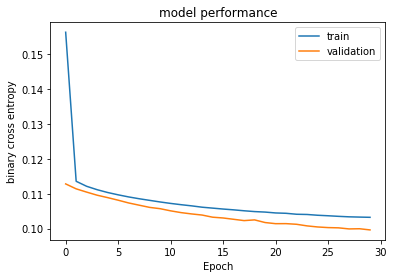

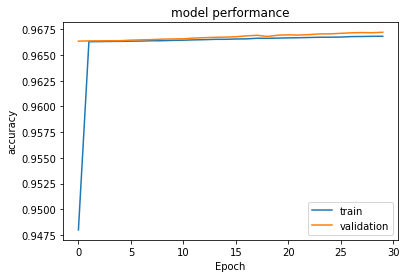

In [91]:
# use the test set and validate 
plt.figure()

# use the history metrics 
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])

plt.title('model performance')
plt.ylabel('binary cross entropy')
plt.xlabel('Epoch')
plt.legend(['train','validation']);
plt.show()

# use the test set and validate 
plt.figure()

# use the history metrics 
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])

plt.title('model performance')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train','validation']);
plt.show()

In [19]:
# # save the trained model 
# model.save('AMT_trained_DNN_trial_model.h5')
# print('model saved')

## model evaluation on test set (unseen data) 

In [20]:
# # load keras model 
# from keras.models import load_model 
# model = load_model('AMT_trained_DNN_trial_model.h5')

In [92]:
# batch size is default = 32 for testing
val_loss,val_acc = model.evaluate(X_test,y_test)
print('test loss : {}, test accuracy : {}'.format(val_loss,val_acc))

45254/45254 [==============================] - 13s 291us/step
test loss : 0.09982186777499666, test accuracy : 0.9670782537868526


## model details 

In [73]:
model.loss

'binary_crossentropy'

In [74]:
model.metrics

['acc']

In [75]:
model.get_config()

{'name': 'sequential_11',
 'layers': [{'class_name': 'Dense',
   'config': {'name': 'dense_51',
    'trainable': True,
    'batch_input_shape': (None, 252),
    'dtype': 'float32',
    'units': 252,
    'activation': 'selu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'RandomNormal',
     'config': {'mean': 0.0, 'stddev': 0.05, 'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dropout',
   'config': {'name': 'dropout_33',
    'trainable': True,
    'rate': 0.2,
    'noise_shape': None,
    'seed': None}},
  {'class_name': 'BatchNormalization',
   'config': {'name': 'batch_normalization_25',
    'trainable': True,
    'axis': -1,
    'momentum': 0.99,
    'epsilon': 0.001,
    'center': True,
    'scale': True,
    'beta_initializer': {'class_name': 'Zeros', 'config'